In this Notebook we will be building a classification model for the plant seedling dataset found on Kaggle at <https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset>.


> The purpose of this model is to use the FastAI library and its associated methodologies. The benefit of using FastAI comes from not only accelearing the process of deep learning but also to make it easier for new beginners to learn the implementation steps easier.



> The code has been run on Google Colab and has used a GPU to acclerate the learning process. The data was also directly accessed using the API token available in Kaggle (if an account has been made and the dataset has been downloaded onto Colab). Since FastAI runs using the Pytorch Torchvision library we first have to determine if all the required libraries have been downloaded successfully.



> In this notebook we wil be building an image classifier that can efficiently detect weeds amongst plants. We have 5539 images present each labelled into namede folders for identification.







In [1]:
# Check if fastai and pytorch are installed
!pip list | grep -e fastai -e torch -e torchvision

fastai                   1.0.57               
torch                    1.1.0                
torchsummary             1.5.1                
torchtext                0.3.1                
torchvision              0.3.0                


Since we are using KAGGLE's API to directly download the data we need to generate an API token. The following code uses the API token that is passed and access the json file. 

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"ganeshmbhat96","key":"e6703257090abf69e8d34c65c9fae164"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#We will now create a new directory called the /content directory as our CWD and place all the dataset zip folders 
import os
if os.getcwd() != '/content':
    os.chdir('/content')
    print("Directory changed.")

In [4]:
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset --force
import zipfile
with zipfile.ZipFile("v2-plant-seedlings-dataset.zip","r") as zip_ref:
    zip_ref.extractall("plant-seedlings-data")

100% 1.59G/1.59G [00:20<00:00, 123MB/s]
100% 1.59G/1.59G [00:20<00:00, 82.6MB/s]


In the following code we will be inspecting the different folders present in the extracted zip file and also the number of images present in each image file. 

In [5]:
#Inspecting the data in the extracted zip folder
import os
labels = os.listdir("plant-seedlings-data")
print("No. of labels: {}".format(len(labels)))
print("-----------------")

for label in labels:
    print("{}, {} files".format(label, len(os.listdir("plant-seedlings-data/"+label))))

No. of labels: 12
-----------------
Common wheat, 253 files
Loose Silky-bent, 762 files
Scentless Mayweed, 607 files
Sugar beet, 463 files
Cleavers, 335 files
Fat Hen, 538 files
Charlock, 452 files
Small-flowered Cranesbill, 576 files
Black-grass, 309 files
Maize, 257 files
Common Chickweed, 713 files
Shepherd’s Purse, 274 files


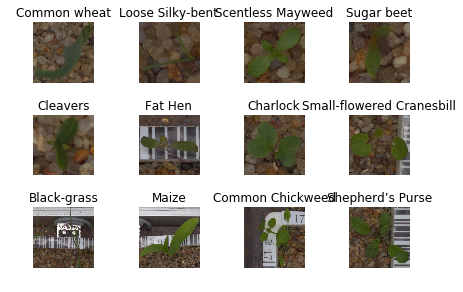

In [6]:
#We will now print an image from each image folder
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig, ax = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()
cnt = 0
for row in ax:
    for col in row:
        image_name = np.random.choice(os.listdir("plant-seedlings-data/" + labels[cnt]))
        im = Image.open("plant-seedlings-data/{}/{}".format(labels[cnt],image_name))
        col.imshow(im)
        col.set_title(labels[cnt])
        col.axis('off')
        cnt += 1
plt.show()

In [0]:
#Importing the FastAI Libraries
from fastai.vision import *
from fastai.metrics import accuracy

Now since we have different number of images in each category and since the size of each image is different we have to come up with an alternative. The bigger the size of the image the better it is for the CNN to run detect the features but the downside is longer compute times with several irregularities and since Colab doesn't offer the GPU memory for extended period of times, I had to set the batch size to a smaller size.


> We will also be using the FastAI class called **ImageDataBunch** for handliing and representing each image in each folder as an object. This class also automatically splits our data into training and validation sets. We have also specfied our path and other hyperparameters as well.


1.   get_transforms() returns a list of available transforrmations upon call.
2.   valid_pct controls the percentage of images that will be part of the validation set.
3.   flip_vert which controls vertical flips in adiition to horizontal flips.







In [0]:
path = '/content/plant-seedlings-data'
size = 224
bs = 64
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(do_flip=True, flip_vert=True),
                                  valid_pct=0.2, size=size, bs=bs)

We are calling the normalize() function such that it will grab a batch of data from each object and compute the mean, standard deviation etc. 

In [18]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (4432 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Common wheat,Common wheat,Common wheat,Common wheat,Common wheat
Path: /content/plant-seedlings-data;

Valid: LabelList (1107 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Charlock,Fat Hen,Loose Silky-bent,Fat Hen,Shepherd’s Purse
Path: /content/plant-seedlings-data;

Test: None

We now use another FastAi library called create_cnn() from the vision modules. This function creates a learner object as a variable. We are specifying the RESNET architecture as our base model that we will be using for transfer learning. So, FastAi API then downloads the architecture and stores it locally. The metric we will be using is accuracy. the ShowGraph tells the class that it should return a graph.  

In [19]:
learner = create_cnn(data, models.resnet18, metrics=[accuracy], callback_fns=ShowGraph)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 113019471.64it/s]


We will now find the optimal learning rate for training. We will now be fitting the model on the epochs and saving for which learning rates the loss decreases the most. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


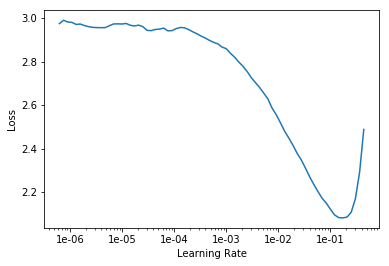

In [20]:
learner.lr_find()
learner.recorder.plot()

We will now fit our model for 8 epochs with a learning rate between 0.001 and 0.01

epoch,train_loss,valid_loss,accuracy,time
0,1.597574,0.655915,0.769648,01:35
1,0.819495,0.384884,0.870822,01:35
2,0.540444,0.221915,0.911472,01:34
3,0.395530,0.218392,0.919603,01:34
4,0.318186,0.162879,0.938573,01:35
5,0.269462,0.161916,0.937669,01:35
6,0.225070,0.139168,0.950316,01:35
7,0.196474,0.138715,0.947606,01:34


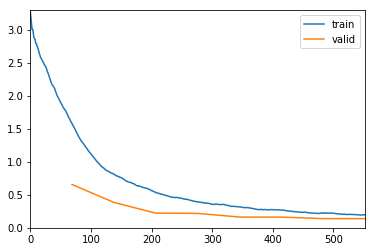

In [21]:
learner.fit_one_cycle(8, max_lr=slice(1e-3, 1e-2))

In the plot above we can see that the loss is decreasing for the inintial iterations and slows down for the remaining part of the training process. Now we have to determine where the algorithm is making errors in i.e the classes it has misclassfied or wrongfully identified.

In [0]:
interpreter = ClassificationInterpretation.from_learner(learner)

In [24]:
interpreter.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 22),
 ('Loose Silky-bent', 'Black-grass', 10),
 ('Shepherd’s Purse', 'Scentless Mayweed', 6),
 ('Black-grass', 'Common wheat', 3),
 ('Scentless Mayweed', 'Common Chickweed', 2)]

As we can see, we have determined that the model has misclassifed 'Black-grass' as 'Loose Silky-bent' most often. If we lookback at the pictures we have generated from each folder we will understand that it is understandable for the model to misclassify the images.  

In [0]:
#Save the weights so that fine tuning of models parameters can take place. 
learner.save('stage-1')
#learner.load('stage-1')

In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.181129,0.135727,0.949413,01:37
1,0.183332,0.129183,0.951219,01:37
2,0.175595,0.130584,0.949413,01:37
3,0.178442,0.123830,0.953026,01:37
4,0.154035,0.111706,0.957543,01:37
5,0.153888,0.105277,0.959350,01:38
6,0.140208,0.096037,0.962963,01:37
7,0.128898,0.100591,0.961156,01:37
8,0.118507,0.089085,0.970190,01:38
9,0.113461,0.089825,0.971996,01:37


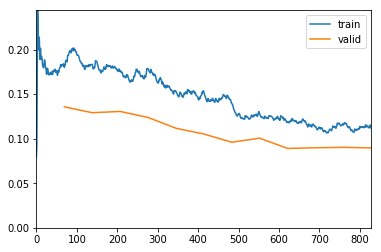

In [27]:
learner.fit_one_cycle(12, max_lr=slice(1e-5, 1e-4))

As we can see the validation error is getting better than the training error and the tendency will only decrease further upon furhter training without the problem of overfitting arisiing atleast for a few more iterations ideally. But the results we have obtained so far show that we have obtained an accuracy of 97.01% using FASTAI.